<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

# Biomarker Discovery

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## Interpreting Models for Biomarker Discovery

While high classification performance is important, understanding **why** a model makes its predictions is equally critical in a clinical context. In personalised medicine and dentistry, we are often interested not just in predicting outcomes, but in uncovering the **biological mechanisms** or **molecular features** that drive those outcomes.

In this task, we used RNA-seq data to classify HPV status. But beyond classification, we can now ask: **Which genes are most strongly associated with HPV-positive or HPV-negative cases?**

This is where model interpretability methods like **SHAP (SHapley Additive exPlanations)** become valuable. SHAP assigns an importance value to each feature (gene), indicating how much it contributed to the model’s prediction for a given sample. When averaged across many samples, these values can highlight **candidate biomarkers** — genes that consistently help distinguish between clinical groups.

Using SHAP, we can begin to move from "black-box" prediction toward biologically meaningful insights, providing a foundation for hypothesis generation, experimental validation, or even clinical test development.


<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## How do SHAP values work?
  
The mathematics of SHAP values is highly complex and we won't talk about it. However, they have a really intuitive explanation.  
  
When our random forest model is making a prediction, it takes the values of all of the genes and uses these to predict whether the sample is HPV-positive or HPV-negative.  
  
However, not all of the genes are **useful** in making this prediction.  
  
There are a few reasons for this: 
* the gene may be similarly expressed in all patients: it provides no differentiating effect
* the gene may not be correlated in any way with the outcome: it provides no information as to whether a patient is HPV-negative or HPV-positive
* the gene may be highly correlated with other genes. If one gene being upregulated *causes* other genes to be upregulated, then the presence of just the "causing" gene is *enough* for the model to make its prediction.  
  
SHAP assigns a value to each gene that the model uses in its prediction. This value tells us how "important" that gene was in making a prediction. The higher the value, the more *important* the gene. 

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

We can use these SHAP values to select just a subset of the genes. This can reduce the number of genes that need to be analysed to a much smaller number: a biomarker panel!  
  
This also allows us to biologically interpret the question we are trying to answer.  
  
By restricting the model to only use a small subset of the genes, we can identify potential pathways that these genes correspond to. This can help us to answer *why* HPV-status influences the gene expression levels in a patient.  
  
In this notebook, we demonstrate this process of using SHAP to build a biomarker panel. You will have a chance to try this out for yourself in the homework notebook. This notebook is really intended as a teaching tool for you to come back to and read if you get stuck

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 1) Build a Model
  
In order to build a biomarker panel, we need to start with a model that uses *all* of the potential genes. This will let us identify what the *important* genes are.  
  
We return to our example of using a random forest to predict HPV-status from gene expression levels. We do not go into any details about the model building process, since you've seen it a few times now!

In [31]:
# import libraries for usage

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

plt.style.use("ggplot")

In [32]:
# this is code that installs and imports the SHAP library, so we can use it for biomarker discovery 
src_dir = "../../../src"
import sys
sys.path.append(src_dir)
from install_if_missing import install_if_missing
install_if_missing("shap", verbose=True)

import shap
np.bool = bool

'shap' is already installed.


In [33]:
df = pd.read_csv("dataset/hnsc_dataset_scaled.csv")

X = df.drop(["HPV_Status", "Patient ID"], axis = 1)
y = df["HPV_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

rf_model = RandomForestClassifier(random_state = 42,
                                n_estimators = 100, 
                                max_depth = 100)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, random_state=42)

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

We are going to produce some metrics to quantify how well this "basic" random forest, using all features, is working. This is so that we can compare it with our biomarker panel later.

In [34]:
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

In [35]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, pos_label = "Positive")
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

In [36]:
print("Accuracy = ", accuracy_rf)
print("F1-Score = ", f1_rf)
print("ROC-AUC = ", roc_auc_rf)

Accuracy =  0.9795918367346939
F1-Score =  0.9883720930232558
ROC-AUC =  0.9981900452488688


<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 2) Using SHAP to identify the most important features  
  
We now use the SHAP library to calculate SHAP scores for each feature.  
  
The first step is to create an "explainer" object.
  
`shap.TreeExplainer` is a specialized SHAP explainer designed for **tree-based models**, such as:
- Decision Trees
- Random Forests
- Gradient Boosted Trees (e.g. XGBoost, LightGBM)

This explainer takes advantage of the internal structure of tree models to efficiently compute **SHAP values**, which measure how much each feature (gene) contributed to a specific prediction. The next cell shows how this is done.

In [37]:
explainer = shap.TreeExplainer(rf_model) # generate a SHAP explainer for our model 

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

We then calculate SHAP values for this model.  
  
******  
N.B.: here, we are calculating SHAP values on the train set. This is technically not correct, since we are not testing on data the model hasn't seen before. However, we cannot use the testing set. The solution to this is to split the dataset into 3: 
* Training
* Testing
* Validation
The testing set is *only* used right at the end. The training set is used as before. The validation set is used for the SHAP calculation. For simplicity, we haven't done this in the exercises in this course (but you should bear it in mind for your work).
*******

In [38]:
shap_values = explainer.shap_values(X_train) # calculate SHAP values for our model for the test set

If we look at the `shap_values` object, we see that it is a list of 2 arrays. The first array in the list is the SHAP values for the negative class (HPV-negative) and the second array is the SHAP values for the positive class (HPV-positive).  
  
Since every patient is always either HPV-positive or HPV-negative, we can take either of these arrays. We will take the first one in the list.

In [39]:
# shap_values is an array of two elements, so just take the first one in the list
shap_values

array([[[ 8.26292043e-05, -8.26292043e-05],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
        [-2.71965565e-05,  2.71965565e-05],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 1.87625220e-05, -1.87625220e-05]],

       [[-4.74903862e-04,  4.74903862e-04],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
        [-2.71965565e-05,  2.71965565e-05],
        [ 0.00000000e+00,  0.00000000e+00],
        [-4.69063051e-05,  4.69063051e-05]],

       [[-1.88591160e-04,  1.88591160e-04],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
        [-2.70794698e-05,  2.70794698e-05],
        [ 0.00000000e+00,  0.00000000e+00],
        [-4.69063051e-05,  4.69063051e-05]],

       ...,

       [[ 8.26292043e-05, -8.26292043e-05],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
     

The values in the array can be both positive and negative. A negative value means that that gene was important in negatively affecting the prediction; that is, the gene being expressed caused the patient to be less likely to be predicted as HPV-positive. To account for this, we just take the absolute values of all the elements (so all of the values are replaced by their positive version).  
  
We do this in the next cell:

In [40]:
abs_shap_values = np.abs(shap_values) # taking the first element of the list

In [41]:
abs_shap_values.shape

(389, 1000, 2)

Looking at the shape of the SHAP values array, we can see that it is of shape (389, 1000). This is because there are 1000 genes, and 389 patients in the training se. SHAP shows how important *every* gene was in making the decision for *every* patient. We want to get a measure of the overall importance across patients, so we can take the mean values across all of the patients.  
  
We do this in the next cell: 

In [42]:
mean_shap_values = np.mean(abs_shap_values, axis = (0,2)) # we take the mean over the 0th axis (the first number in abs_shap_values.shape)

In [43]:
mean_shap_values.shape 

# our array now has 1 element for each gene, which is the average absolute importance of that gene in making a prediction

(1000,)

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

The code in the next cell is complicated, but it combines the SHAP values with the names of the genes to produce a table showing the name of each gene and its average SHAP value. The genes are given in descending order of importance.  
  
The higher the SHAP value, the more important the gene is in making a prediction. 
  
If a gene has a SHAP value of 0.0, this means that it is completely redundant information. It doesn't help at all with the question that we are asking: which genes help to distinguish between patients who are HPV-positive and HPV-negative?

In [44]:
shap_df = pd.DataFrame(
    data = sorted(
        dict(zip(rf_model.feature_names_in_, mean_shap_values)).items(), 
        key = lambda x: x[1], 
        reverse = True
        ),
    columns = ["Gene", "Mean_SHAP_Value"]
)

In [45]:
shap_df

,Gene,Mean_SHAP_Value
0,TCAM1P,0.015975
1,TCP11,0.012331
2,ZYG11A,0.010299
3,MIR9-3HG,0.009701
4,YBX2,0.008135
...,...,...
995,FAM181B,0.000000
996,AREG,0.000000
997,MT1L,0.000000
998,UPK1A,0.000000


In [46]:
shap_df.head(10)

,Gene,Mean_SHAP_Value
0,TCAM1P,0.015975
1,TCP11,0.012331
2,ZYG11A,0.010299
3,MIR9-3HG,0.009701
4,YBX2,0.008135
5,FOLR3,0.007241
6,KCNS1,0.006804
7,PODXL2,0.006257
8,MAP7D2,0.004891
9,MYO3A,0.004813


<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

This analysis shows that the 10 most important genes in predicting the HPV-status from mRNA-seq data are: 
* TCAM1P
* MIR9-3HG
* TCP11
* ZYG11A
* YBX2
* KCNS1
* PODXL2
* FOLR3
* MAP7D2
* CHDH  

It also shows that many genes, for example FOXC2 and UPK1A are not at all relevant in predicting the HPV status.
  
Do these seem sensible? 

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 3) Using SHAP to produce a reduced model
  
So now we have identified which genes are the most important to the model in making predictions. This will allow us to define a biomarker panel.  
  
The simplest way to do this is to just take a certain top number of genes and see how well the model performs.  
  
The code below shows how we can extract the names of the top 30 most important genes, according to the shape scores

In [47]:
# this code takes the top 30 most important genes, and then takes the "Gene" column only out of shap_df
top30_genes = shap_df.iloc[:30,]["Gene"]

# this code makes the gene names into a list so that we can see them all
top30_genes = list(top30_genes)

In [48]:
top30_genes

# you can see that we hve the top30 most important genes here

['TCAM1P',
 'TCP11',
 'ZYG11A',
 'MIR9-3HG',
 'YBX2',
 'FOLR3',
 'KCNS1',
 'PODXL2',
 'MAP7D2',
 'MYO3A',
 'CHDH',
 'CDKN2A',
 'CDA',
 'FAM3B',
 'RNF212',
 'DSCR6',
 'KHDC1L',
 'CXCL14',
 'TCHHL1',
 'CALB2',
 'RNASE10',
 'PNLIPRP3',
 'C11orf87',
 'PAEP',
 'LHX2',
 'KLK9',
 'GLS2',
 'CYP4X1',
 'SYT1',
 'TMPRSS2']

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

Now let's build a random forest model using only these genes.  
  
If we have a list of gene names, such as `top30_genes` here, we can get a dataset that *only* contains those genes using this code:

```
X_top30 = X[top30_genes]
```

In [49]:
X_train[top30_genes].head()

# we should see that only 30 columns appear, for the 30 genes that we are going to use in classification

,TCAM1P,TCP11,ZYG11A,MIR9-3HG,YBX2,FOLR3,KCNS1,PODXL2,MAP7D2,MYO3A,...,RNASE10,PNLIPRP3,C11orf87,PAEP,LHX2,KLK9,GLS2,CYP4X1,SYT1,TMPRSS2
415,-0.350022,0.100729,-0.077693,-0.502351,-0.930156,0.080499,0.556221,-0.518364,-0.969386,-0.891329,...,2.134340,1.624940,1.538907,1.029121,-2.119866,0.626007,-0.874297,-0.424761,-1.014996,0.186001
314,-0.462006,-0.734563,0.226956,-0.379242,-1.530028,1.000075,0.539791,0.490427,-0.572726,-0.174738,...,0.492717,1.211518,-0.609166,1.046323,-1.595997,1.143634,-1.174344,-0.122410,1.250515,0.049496
25,-1.110652,-0.564395,-0.387757,-0.748706,-0.424160,0.529103,-0.899867,-0.604987,-0.848081,-1.085683,...,1.889043,0.653758,0.146920,1.471398,-1.316974,1.806422,-1.245657,-0.487055,-2.360357,0.297736
222,-0.438386,-0.996797,-0.450007,-0.879964,-1.273211,0.088901,-0.552218,0.523193,0.961964,1.089780,...,-0.337373,-0.133472,2.142987,-0.624897,-0.096908,-1.151661,0.596344,-0.031953,0.866016,-0.647788
298,0.225256,-0.996797,0.934417,0.484370,0.731422,-1.187036,0.621127,0.118854,1.514601,1.495626,...,1.114637,0.194456,0.972523,-0.515221,1.235262,0.213811,1.324820,0.073332,0.843755,1.373416


In [50]:
# we set up a new RandomForestClassifier, using the same hyperparameters as we had before

new_model = RandomForestClassifier(random_state = 42, 
                                    max_depth = 10, 
                                    n_estimators = 100)

# we train this new model, but we *only* use our top 30 genes
new_model.fit(X_train[top30_genes], 
                y_train)

RandomForestClassifier(max_depth=10, random_state=42)

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

Let's now evaluate the random forest classifier that only used our hypothetical biomarker panel

In [51]:
y_pred = new_model.predict(X_test[top30_genes]) # model should only make predictions using the top30 genes

y_proba = new_model.predict_proba(X_test[top30_genes])[:,1]

In [52]:
y_pred

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Negative', 'Positive', 'Positive', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Negative', 'Positive', 'Negative', 'Positive',
       'Negative', 'Positive', 'Negative', 'Negative', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positi

In [53]:
new_accuracy = accuracy_score(y_test, y_pred)
new_f1 = f1_score(y_test, y_pred, pos_label = "Positive")
new_roc_auc_score = roc_auc_score(y_test, y_proba)

In [54]:
print("New Accuracy = ", new_accuracy)
print("New F1 = ", new_f1)
print("New ROC-AUC-Score", new_roc_auc_score)

New Accuracy =  0.9897959183673469
New F1 =  0.9941520467836257
New ROC-AUC-Score 1.0


<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

We can also plot the ROC curves for the two cases to compare

In [55]:
false_positive_rate_rf, true_positive_rate_rf, thres_rf = roc_curve(y_test, y_proba_rf, pos_label = "Positive")

false_positive_rate_new_model, true_positive_rate_new_model, thres_new_model = roc_curve(y_test, y_proba, pos_label = "Positive")

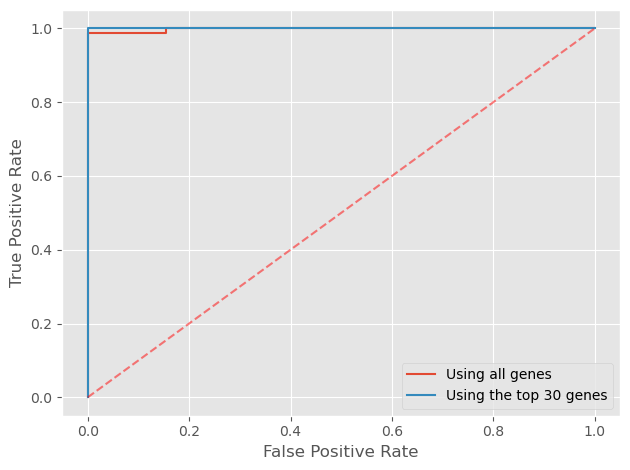

In [56]:
fig, ax = plt.subplots()

# plot the ROC curve for the random forest
ax.plot(false_positive_rate_rf, true_positive_rate_rf, label = "Using all genes")

# plot the ROC curve for the decision tree
ax.plot(false_positive_rate_new_model, true_positive_rate_new_model, label = "Using the top 30 genes")

# plot the ROC curve that a coinflip would have
ax.plot([0,1], [0,1], color = 'red', alpha = 0.5, linestyle = '--')

# set x and y labels 
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

# add the legend to the plot 
ax.legend()

fig.tight_layout()

plt.show()

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## Biomarker Panel Performance

We evaluated the performance of the model using all 1000 genes compared to a refined panel of the top 30 genes selected using SHAP-based feature importance.

| Metric         | Full Model (1000 genes) | Biomarker Panel (30 genes) | % Improvement |
|----------------|--------------------------|------------------------------|----------------|
| **Accuracy**   | 0.976                    | 0.990                        | +1.43%         |
| **F1-score**   | 0.988                    | 0.994                        | +0.61%         |
| **ROC-AUC**    | 0.998                    | 1.000                        | +0.20%         |

### Interpretation

Despite using only 3% of the original features, the biomarker panel not only **matched** but in fact **slightly outperformed** the full model across all evaluation metrics:

- **Accuracy** improved by 1.43%, indicating fewer classification errors overall.
- **F1-score** increased slightly, reflecting better balance between precision and recall.
- **ROC-AUC** reached a perfect score of 1.0, suggesting the simplified model can perfectly distinguish between HPV-positive and HPV-negative cases in this dataset.

### Conclusion

This result strongly supports the idea that a **small, well-selected gene panel** can retain — or even improve — classification performance. From a clinical perspective, this has important implications for cost-effective diagnostics and targeted molecular assays, where smaller panels are often more practical and scalable.  
  
This approach to selecting a smaller number of genes is extremely powerful!
